# 0.0 - Decision Tree

O parâmetro utilizado para treinar o algoritmo **Decision Tree** será a profundidade máxima da árvore, o `max_depth`. O valor padrão é `None` segundo a documentação oficial acessada na página:

https://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeClassifier.html

- `max_depth`: *"The maximum depth of the tree. If `None`, then nodes are expanded until all leaves are pure or until all leaves contain less than **min_samples_split** samples"*.

*Por padrão, a árvore se expande até que todas as folhas sejam puras ou até que contenham um número de amostras menor que o valor default do parâmetro `min_samples_split`, 2 amostras*.

# 1.0 - Importando bibliotecas

In [1]:
import pandas as pd
import numpy as np
from sklearn import tree as tr
from sklearn import metrics as mt
from matplotlib import pyplot as plt

# 2.0 - Carregando os dados

In [2]:
# Treino
X_train = pd.read_csv('data/train/X_training.csv')
y_train = pd.read_csv('data/train/y_training.csv')

# Validação
X_val = pd.read_csv('data/validation/X_validation.csv')
y_val = pd.read_csv('data/validation/y_validation.csv')

# Teste
X_test = pd.read_csv('data/test/X_test.csv')
y_test = pd.read_csv('data/test/y_test.csv')

# 3.0 - Funções

In [3]:
def metrics(y, y_pred, step, algorithm):
    """
    Calcula várias métricas de avaliação de um modelo de classificação e as retorna em um DataFrame.

    Parâmetros:
    -----------
    y : array-like
        Valores da variável resposta.
    
    y_pred : array-like
        Valores preditos pelo modelo.
    
    step : str
        Etapa do processo de modelagem (ex: 'treino', 'validação', 'teste').
    
    algorithm : str
        Nome do algoritmo usado.

    Retorno:
    --------
    df_metrics : pandas.DataFrame
        DataFrame contendo as métricas calculadas:
        - 'Algorithm': Nome do algoritmo.
        - 'Step': Etapa do processo (treino, validação ou teste).
        - 'Accuracy': Valor da Acurácia.
        - 'Precision': Valor da Precision.
        - 'Recall': Valor da Recall.
        - 'F1-Score': Valor de F1-Score.
    """
    # Calcula as métricas
    # Observação: considerei a classe positiva como sendo '0', 
    # de forma que o argumento de 'pos_label' abaixo é nulo.
    # Por padrão, o sklearn representa a mesma classe como sendo '1'. 
    acuracia  = mt.accuracy_score( y, y_pred )
    precision = mt.precision_score( y, y_pred, pos_label = 0 )
    recall    = mt.recall_score( y, y_pred, pos_label = 0 )
    f1        = mt.f1_score( y, y_pred, pos_label = 0 )

    # Cria o DataFrame com as métricas
    df_metrics = pd.DataFrame({   
        'Algorithm': [algorithm],
        'Step': [step],
        'Accuracy': [np.round(acuracia, 4)],
        'Precision': [np.round(precision, 4)],
        'Recall': [np.round(recall, 4)],
        'F1-Score': [np.round(f1, 4)]
    })
    
    return df_metrics

def exporta_excel(nome_algoritmo):
    """
    Exporta os DataFrames de métricas para arquivos Excel em diferentes pastas.

    Args:
        nome_algoritmo (str): Nome do algoritmo utilizado.

    Returns:
        None
    """
    etapas = ['train', 'validation', 'test']
    df_list = [df_metrics_train, df_metrics_val, df_metrics_test]

    for etapa, df in zip(etapas, df_list):
        df.to_excel(f'metrics/{etapa}/{nome_algoritmo}_{etapa}.xlsx', index=False)

# 4.0 - Ajustando os dados

In [4]:
# Como o atributo 'id' não contribui para o aprendizado do modelo, iremos retirá-lo.
X_train, X_val, X_test = [ df.drop(columns = ['id']) for df in [X_train, X_val, X_test] ]

In [5]:
# renomeia a coluna '0' com o nome original 'satisfaction'
y_train, y_val, y_test = [ df.rename(columns = {'0': 'satisfaction'}) for df in [y_train, y_val, y_test] ]

In [6]:
# transformação do formato DataFrame para Series, essencialmente um array unidimensional
y_train, y_val, y_test = [ df.loc[:, 'satisfaction'] for df in [y_train, y_val, y_test] ]

# 5.0 - Desempenho do modelo

## 5.1 - Dados de treino

In [7]:
# Definição do modelo
# Vamos iniciar com 'max_depth' = None (valor padrão)
decision_tree_train = tr.DecisionTreeClassifier( random_state = 0 )

# Treinamento do algoritmo. 
decision_tree_train.fit(X_train, y_train)

# Predição sobre os dados de treino
y_pred_train = decision_tree_train.predict(X_train)

# Métricas
df_metrics_train = metrics(y_train, y_pred_train, 'Train', 'Decision Tree')
df_metrics_train

,Algorithm,Step,Accuracy,Precision,Recall,F1-Score
0,Decision Tree,Train,1.0,1.0,1.0,1.0


## 5.2 - Dados de validação

In [8]:
# Definindo o modelo
decision_tree_val = tr.DecisionTreeClassifier( random_state = 0 )

# Treinamento do algoritmo
decision_tree_val.fit(X_train, y_train)

# Treina com dados de treino e aplica sobre os dados de validação
y_pred_val = decision_tree_val.predict(X_val)

# Métricas
df_metrics_val = metrics(y_val, y_pred_val, 'Validation', 'Decision Tree')
df_metrics_val

,Algorithm,Step,Accuracy,Precision,Recall,F1-Score
0,Decision Tree,Validation,0.9444,0.9536,0.948,0.9508


## 5.3 - Ajuste fino dos hiperparâmetros (Etapa de *Fine Tuning*)

In [9]:
# array para os valores testados de 'max_depth' (máxima profundidade da árvore)
max_depth_array = np.arange(2, 31, 1)   

# Criar DataFrame para armazenar resultados
metrics_df = pd.DataFrame(columns=['max_depth', 'accuracy', 'precision', 'recall', 'f1_score'])

for m in max_depth_array:
    # Definir e treinar o modelo
    model = tr.DecisionTreeClassifier( max_depth = m, random_state = 0 ) 
    model.fit(X_train, y_train)
    
    # Array de predições 
    y_pred = model.predict(X_val)
    
    # Calcular métricas de performance
    acuracia = mt.accuracy_score( y_val, y_pred)
    precision = mt.precision_score( y_val, y_pred, pos_label = 0)
    recall = mt.recall_score( y_val, y_pred, pos_label = 0)
    f1 = mt.f1_score( y_val, y_pred, pos_label = 0)
    
    # Armazenar os resultados em uma nova linha como DataFrame
    new_row = pd.DataFrame({
        'max_depth': [m],
        'accuracy': [acuracia],
        'precision': [precision],
        'recall': [recall],
        'f1_score': [f1]
    })

    # Concatenar a nova linha ao DataFrame existente
    metrics_df = pd.concat([metrics_df, new_row], ignore_index=True)

In [10]:
# DataFrame com os valores das métricas de performance para os valores de 'max_depth' testados
metrics_df

,max_depth,accuracy,precision,recall,f1_score
0,2,0.856495,0.877223,0.868257,0.872717
1,3,0.885453,0.925139,0.868086,0.895705
2,4,0.893465,0.874221,0.948438,0.909819
3,5,0.906689,0.906803,0.931005,0.918745
4,6,0.921748,0.945678,0.914424,0.929788
5,7,0.931497,0.922724,0.959455,0.940731
6,8,0.936227,0.937025,0.951391,0.944153
7,9,0.940056,0.931118,0.965645,0.948067
8,10,0.943048,0.937908,0.963260,0.950415
9,11,0.945976,0.944627,0.960988,0.952738


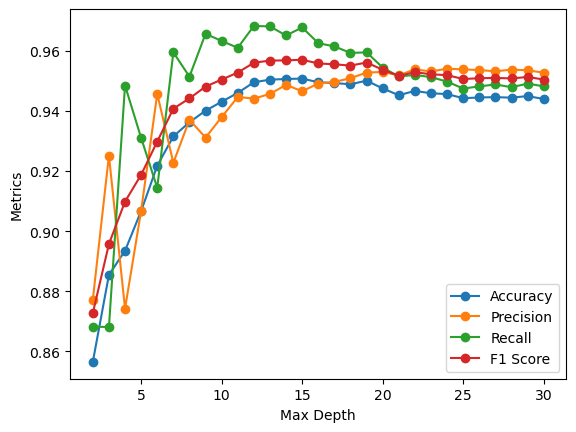

In [11]:
# Gráficos de cada métrica pela máxima profundidade da árvore
plt.plot(max_depth_array, metrics_df['accuracy'], marker="o", label="Accuracy")
plt.plot(max_depth_array, metrics_df['precision'], marker="o", label="Precision")
plt.plot(max_depth_array, metrics_df['recall'], marker="o", label="Recall")
plt.plot(max_depth_array, metrics_df['f1_score'], marker="o", label="F1 Score")
plt.xlabel("Max Depth")
plt.ylabel("Metrics")
plt.legend();

Como o objetivo principal da pesquisa é identificar os clientes insatisfeitos para tomar ações corretivas, o **recall** é a figura de mérito mais relevante.  
Assim, um alto **recall** garante que a maioria dos clientes insatisfeitos seja corretamente identificada.  
O melhor valor de **max_depth** é aquele que produz o maior valor da métrica de interesse.

In [12]:
metrics_df.sort_values(by='recall', ascending=False).head(1)

,max_depth,accuracy,precision,recall,f1_score
10,12,0.949516,0.944078,0.968257,0.956015


In [13]:
# melhor valor de 'max_depth'
best_max_depth = 12

## 5.4 - Desempenho do modelo para os dados de teste

In [14]:
# definição do modelo
decision_tree_test = tr.DecisionTreeClassifier( max_depth = best_max_depth, random_state = 0 )

# Juntar os dados de treino e validação
decision_tree_test.fit( pd.concat( [X_train, X_val] ),
                        pd.concat( [y_train, y_val] ) )

# Predição sobre os dados de teste
y_pred_test = decision_tree_test.predict( X_test )

# Métricas
df_metrics_test = metrics(y_test, y_pred_test, 'Test', 'Decision Tree')
df_metrics_test

,Algorithm,Step,Accuracy,Precision,Recall,F1-Score
0,Decision Tree,Test,0.9528,0.9471,0.9702,0.9585


# 6.0 - Gera as planilhas com os resultados

In [15]:
exporta_excel('Decision_Tree')